# Determine whether an image contains a columnar cactus using Convolutional Neural Network (CNN) with Fastai

### Writer: Amrik Singh
<i class="fa fa-linkedin" style="font-size:20px"></i>&nbsp;
[linkedin.com/in/amrik220/](https://www.linkedin.com/in/amrik220/)&emsp;
<i class="fa fa-github" style="font-size:20px"></i>&nbsp;
[github.com/amrik220](https://github.com/amrik220)

***

# Introduction

This notebook contains Python code to determine whether an image contains a columnar cactus or not using Convolutional Neural Network (CNN) with Fastai. The dataset is from [Aerial Cactus Identification, a Kaggle Competition](https://www.kaggle.com/c/aerial-cactus-identification/overview). The dataset can be download from [here](https://www.kaggle.com/c/aerial-cactus-identification/data) and has following files:
1. train: training set of 17,500 (32 x 32) thumbnails
2. train.csv: training set lables, positive class has_cactus = 1

For the purpose of this task, the train dataset will be split into train (.64), validation (.16), test (.2) sets.

Programming Environment: Python 3.6.9 and Google Colaboratory

# Set up environment and explore data

In [2]:
# Display output of all code lines in Jupyter notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

!python --version # Check python version
!jupyter-notebook --version

Python 3.6.9
5.2.2


## Import required libraries and functions

In [3]:
# Import required libraries and functions
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

import torch
from fastai import *
from fastai.vision import *

In [4]:
# Clone the GitHub respository containing the data files to Colaboratory
import os
if os.path.exists('/content/imageProcessing') == False:
  !git clone https://github.com/amrik220/imageProcessing

In [5]:
# load data labels from the csv file
path = '/content/imageProcessing/aerial_cactus_identification/'
labels = pd.read_csv(path + 'train.csv')

labels.head()
labels.shape

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


(17500, 2)

In [6]:
# check class balance
table = labels.has_cactus.value_counts()
table
not_cactus = table[0]
cactus = table[1]

text = "\n\nPercentage of cactus: {:.2f}\nPercentage of not_cactus: {:.2f}"
print(text.format(cactus/(cactus+not_cactus)*100, not_cactus/(cactus+not_cactus)*100))

1    13136
0     4364
Name: has_cactus, dtype: int64



Percentage of cactus: 75.06
Percentage of not_cactus: 24.94


Split data into training and test set

In [7]:
# Split data into training and test set
trainLabels, testLabels = train_test_split(labels, test_size = 0.2, random_state=220)

**Preview images containing cactus**

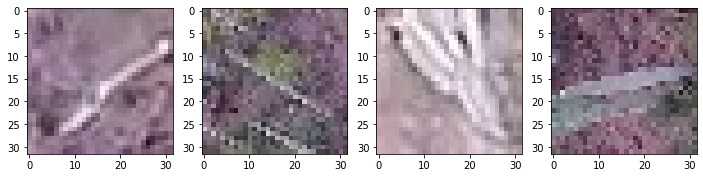

In [8]:
fig,ax = plt.subplots(nrows=1,ncols=4, figsize=(12,3))
for i,idx in enumerate(trainLabels[trainLabels['has_cactus'] == 1]['id'][0:4]):
    img_path = os.path.join(path,'train', idx)
    # print(img_path)
    ax[i].imshow(img.imread(img_path))

**Preview images not containing cactus**

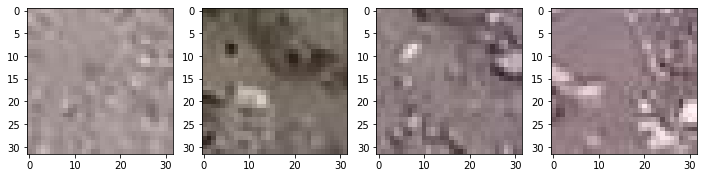

In [9]:
fig,ax = plt.subplots(nrows=1,ncols=4, figsize=(12,3))
for i,idx in enumerate(trainLabels[trainLabels['has_cactus'] == 0]['id'][0:4]):
    img_path = os.path.join(path,'train', idx)
    # print(img_path)
    ax[i].imshow(img.imread(img_path))

## Load images

In [10]:
# load training set images
train_img = ImageList.from_df(trainLabels, path= path+'train')
test_img = ImageList.from_df(testLabels, path= path+'train')
train_img
test_img

ImageList (14000 items)
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: /content/imageProcessing/aerial_cactus_identification/train

ImageList (3500 items)
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
Path: /content/imageProcessing/aerial_cactus_identification/train

# Build CNN with Fastai

In [11]:
transformations = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, 
                                 max_zoom=1.1, max_lighting=0.2, max_warp=0.2, 
                                 p_affine=0.75, p_lighting=0.75)

In [13]:
model_img = (train_img
        .split_by_rand_pct(0.01)
        .label_from_df()
        .add_test(test_img)
        .transform(transformations, size=128)
        .databunch(path='.', bs=64)
        .normalize(imagenet_stats)
       )
      # .databunch(path='.', bs=64, device= torch.device('cuda:0')) # CUDA-capable device


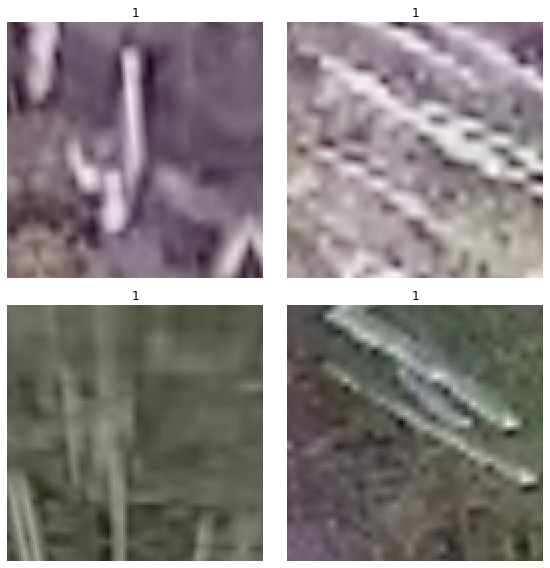

In [33]:
model_img.show_batch(rows=2, figsize=(8,8))

# Train the model

In [34]:
trained_model = cnn_learner(model_img, models.densenet161, metrics=[error_rate, accuracy])

# Available models in fastai
# resnet18, resnet34, resnet50, resnet101, resnet152
# squeezenet1_0, squeezenet1_1
# densenet121, densenet169, densenet201, densenet161
# vgg16_bn, vgg19_bn
# alexnet

In [35]:
trained_model.lr_find()
trained_model.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

In [ ]:
lr = 3e-02
trained_model.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,time


In [18]:
preds,_ = trained_model.get_preds(ds_type=DatasetType.Valid)

In [20]:
pred = preds.numpy()[:, 0]

In [21]:
pred

array([0.377317, 0.238664, 0.919167, 0.931071, ..., 0.325709, 0.985   , 0.3951  , 0.922916], dtype=float32)

In [23]:
interpreter = ClassificationInterpretation.from_learner(trained_model)


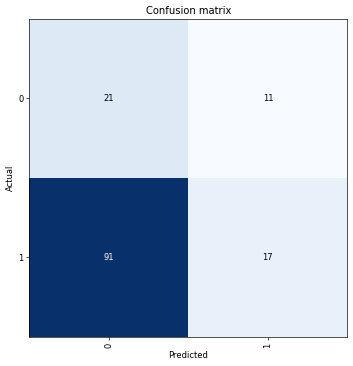

In [24]:
interpreter.plot_confusion_matrix(figsize=(6,6), dpi=60)


In [ ]:
preds,_ = trained_model.get_preds(ds_type=DatasetType.Train)

# Prediction

# References
1. https://www.kaggle.com/kenseitrg/simple-fastai-exercise
2. https://www.kaggle.com/navneeth/feedforward-cnn-fastai
3. https://www.kaggle.com/umangjpatel/aerial-cactus-cnn